# Planteles Educativos Rep. Dom.

### Analisis exploratorio y descriptivo del dataset que contiene los mas de 7,000 planteles educativos de Rep. Dom, y los matriculados al año 2021. Agregando valor al analisis con un mapa donde se puede visualizar por niveles todos los puntos espaciales, para lo mismo usamos varias librerias:

* Pandas
* Numpy
* Fiona
* Geopandas
* Pandas Profiling
* SweetVitz
* Matplotlib
* Plotly

Fuente https://datos.gob.do/dataset/centros-educativos-de-republica-dominicana/resource/42486490-51a6-4001-9349-db4604ee06a9

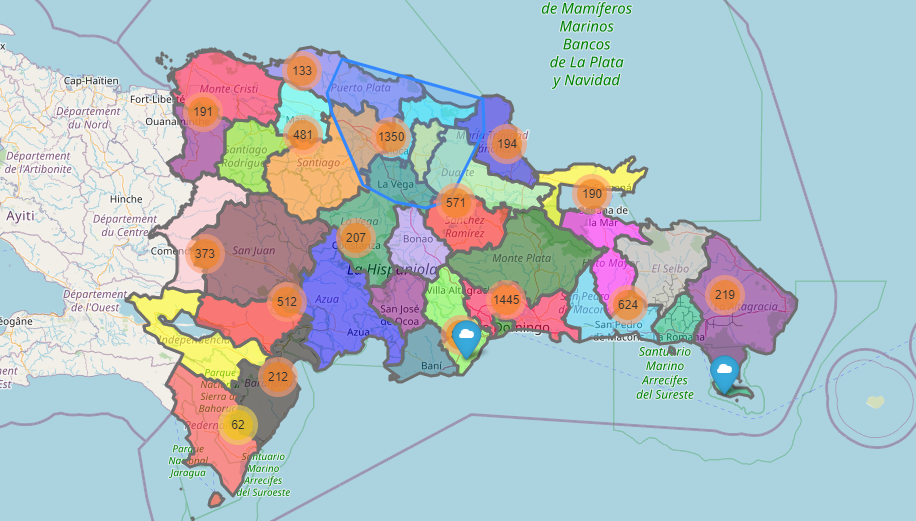

In [1]:
# Librerias

In [2]:
!pip install sweetviz
!pip install pandasprofiling
!pip install ipywidgets

import pandas as pd
import folium
import branca
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
from folium import Marker

import fiona
import geopandas as gpd
import shapefile
import openpyxl
import numpy as np
import webbrowser
import pandas_profiling as pp
import sweetviz as sv
import pandas_profiling as pp
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import math

import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from IPython.display import HTML


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 19.6 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement pandasprofiling (from versions: none)
ERROR: No matching distribution found for pandasprofiling


/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# DATASETS

In [3]:
provincias_shp = gpd.\
read_file('/kaggle/input/shape-files-rd/SHP_RD_2010/PROVCenso2010.shp')
sectores = gpd.read_file('/kaggle/input/shape-files-rd/SHP_RD_2010/SECCenso2010.shp')
barrios = gpd.read_file('/kaggle/input/shape-files-rd/SHP_RD_2010/BPCenso2010.shp')
provincias_rd = pd.read_excel('/kaggle/input/dominican-republic-provincias-coord/tbl_GEO_Provincias.xlsx')
municipios = gpd.read_file('/kaggle/input/shape-files-rd/SHP_RD_2010/MUNCenso2010.shp')
df = pd.read_excel('/kaggle/input/centros-educativos-rd/Tdb-centros-educativos-de-republica-dominicana-2021.xlsx')

df['Cordenadas Latitud'] = df['Cordenadas Latitud'].astype('float',errors ="ignore")
df['Cordenadas Longitud'] = df['Cordenadas Longitud'].astype('float',errors ="ignore")

df.rename(columns = {'MatrÍcula total':'Matricula_Total','Personal Docente':'Personal_Docente'\
                     ,'Planta Física':'Planta_Fisica'}, inplace = True)

#////////////////////////////////////////////////////////////////////////////////////////////////////////////

df_1 = df = pd.merge(df,provincias_rd[['Cod_Provincia','Provincia','Superficie_km']],how='left',left_on='Provincia',
                        right_on='Provincia')


df = df_1

In [4]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7604 entries, 0 to 7603
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Regional             7604 non-null   object 
 1   Distrito             7604 non-null   object 
 2   Centros              7604 non-null   object 
 3   Sector               7604 non-null   object 
 4   Niveles              7604 non-null   object 
 5   Cordenadas Latitud   7604 non-null   float64
 6   Cordenadas Longitud  7604 non-null   float64
 7   Matricula_Total      7604 non-null   int64  
 8   Personal_Docente     7604 non-null   int64  
 9   Planta_Fisica        7604 non-null   object 
 10  Provincia            7604 non-null   object 
 11  Municipio            7604 non-null   object 
 12  Cod_Provincia        7332 non-null   float64
 13  Superficie_km        7332 non-null   float64
dtypes: float64(4), int64(2), object(8)
memory usage: 891.1+ KB
None
        Regional        

# Mapa de la ubicacion Planteles de Republica Dominicana

In [5]:
### Establecer Mapa
escuelas_map = folium.Map(location=[18.4714484,-69.9334167], zoom_start=13)

### Creamos columnas para icono y su color mediante una funcion

def asignIcon (df):

    if df['Niveles'] == "INICIAL - PRIMARIO - SECUNDARIO":
        return 'glyphicon-flag'
    elif df['Niveles'] == "INICIAL - PRIMARIO":
        return 'glyphicon-sunglasses'
    elif df['Niveles'] == "PRIMARIO":
        return 'glyphicon-tags'
    elif df['Niveles'] == "BASICA DE ADULTOS":
         return 'glyphicon-star'
    elif df['Niveles'] == "SECUNDARIO":
         return 'glyphicon-tower' 
    elif df['Niveles'] == "PREPARA":
         return 'glyphicon-circle-arrow-up'
    elif df['Niveles'] == "INICIAL":
         return 'glyphicon-lock'
    elif df['Niveles'] == "PRIMARIO - SECUNDARIO":
         return 'glyphicon-briefcase'
    elif df['Niveles'] == "PREPARA - BASICA DE ADULTOS":
         return 'glyphicon-home'
    elif df['Niveles'] == "INICIAL - SECUNDARIO":
         return 'glyphicon-home'    
    else: 
        return 'cloud'  
df['asignIcon'] = df.apply(asignIcon, axis=1)



mk = MarkerCluster()
for _index, row in df.iterrows():
      mk.add_child(folium.Marker(location=[row['Cordenadas Latitud'], row['Cordenadas Longitud']], 
                                 icon=folium.Icon(icon=row['asignIcon']))).add_to(escuelas_map)

#### CAPAS PROVINCIAS ####

highlight_function = lambda x: {'fillColor': '#000000', 
                                    'color':'#000000', 
                                    'fillOpacity': 0.50, 
                                    'weight': 0.1}
prov_layer=folium.GeoJson(
            provincias_shp,
            name='Provincias',
            highlight_function = highlight_function,
            style_function=lambda x: {
                        'fillColor':'green' if x['properties']['PROV'] == "01"
                                            else 'blue' if "02" == x['properties']['PROV'] 
                                            else 'red' if "03" == x['properties']['PROV'] 
                                            else 'lightred'if "04" == x['properties']['PROV'] 
                                            else 'purple'if "05" == x['properties']['PROV'] 
                                            else 'lightgreen'if "06" == x['properties']['PROV'] 
                                            else 'pink'if "07" == x['properties']['PROV'] 
                                            else 'darkgrey'if "08" == x['properties']['PROV'] 
                                            else 'cyan'if "09" == x['properties']['PROV'] 
                                            else 'yellow'if "10" == x['properties']['PROV'] 
                                            else '#6A0888'if "11" == x['properties']['PROV'] 
                                            else '#04B486'if "12" == x['properties']['PROV'] 
                                            else '#088A4B'if "13" == x['properties']['PROV'] 
                                            else '#0101DF'if "14" == x['properties']['PROV']
                                            else '#FF0040'if "15" == x['properties']['PROV']
                                            else '#FE2E2E'if "16" == x['properties']['PROV']
                                            else '#086A87'if "17" == x['properties']['PROV']
                                            else '#5858FA'if "18" == x['properties']['PROV']
                                            else '#D0FA58'if "19" == x['properties']['PROV']
                                            else 'yellow'if "20" == x['properties']['PROV'] 
                                            else '#64FE2E'if "21" == x['properties']['PROV'] 
                                            else '#610B21'if "22" == x['properties']['PROV'] 
                                            else '#2ECCFA'if "23" == x['properties']['PROV'] 
                                            else '#FF0000'if "24" == x['properties']['PROV']
                                            else '#FF8000'if "25" == x['properties']['PROV']
                                            else '#74DF00'if "26" == x['properties']['PROV']
                                            else '#2EFEF7'if "27" == x['properties']['PROV']
                                            else '#9F81F7'if "28" == x['properties']['PROV']
                                            else '#0B610B'if "29" == x['properties']['PROV']
                                            else '#FF00FF'if "30" == x['properties']['PROV']
                                            else 'purple'if "31" == x['properties']['PROV']
                                            else '#FF0040'if "32" == x['properties']['PROV'] else 'orange',
                        'fillOpacity': 0.5,
                        'color' : '#6E6E6E'
                                        },
          tooltip=folium.GeoJsonTooltip(
            fields=['PROV','TOPONIMIA'],
            aliases=['No.:','Nombre:'],
            style=('background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;'),

            localize=True
    )).add_to(escuelas_map)

#### CAPA DE BARRIOS ######


prov_layer=folium.GeoJson(
            sectores,
            name='Sectores',
            highlight_function = highlight_function,
            style_function=lambda x: {
                    'fillColor':'green' if x['properties']['PROV'] == "01"
                                        else 'blue' if "02" == x['properties']['PROV'] 
                                        else 'red' if "03" == x['properties']['PROV'] 
                                        else 'lightred'if "04" == x['properties']['PROV'] 
                                        else 'purple'if "05" == x['properties']['PROV'] 
                                        else 'lightgreen'if "06" == x['properties']['PROV'] 
                                        else 'pink'if "07" == x['properties']['PROV'] 
                                        else 'darkgrey'if "08" == x['properties']['PROV'] 
                                        else 'cyan'if "09" == x['properties']['PROV'] 
                                        else 'yellow'if "10" == x['properties']['PROV'] 
                                        else '#6A0888'if "11" == x['properties']['PROV'] 
                                        else '#04B486'if "12" == x['properties']['PROV'] 
                                        else '#088A4B'if "13" == x['properties']['PROV'] 
                                        else '#0101DF'if "14" == x['properties']['PROV']
                                        else '#FF0040'if "15" == x['properties']['PROV']
                                        else '#FE2E2E'if "16" == x['properties']['PROV']
                                        else '#086A87'if "17" == x['properties']['PROV']
                                        else '#5858FA'if "18" == x['properties']['PROV']
                                        else '#D0FA58'if "19" == x['properties']['PROV']
                                        else 'yellow'if "20" == x['properties']['PROV'] 
                                        else '#64FE2E'if "21" == x['properties']['PROV'] 
                                        else '#610B21'if "22" == x['properties']['PROV'] 
                                        else '#2ECCFA'if "23" == x['properties']['PROV'] 
                                        else '#FF0000'if "24" == x['properties']['PROV']
                                        else '#FF8000'if "25" == x['properties']['PROV']
                                        else '#74DF00'if "26" == x['properties']['PROV']
                                        else '#2EFEF7'if "27" == x['properties']['PROV']
                                        else '#9F81F7'if "28" == x['properties']['PROV']
                                        else '#0B610B'if "29" == x['properties']['PROV']
                                        else '#FF00FF'if "30" == x['properties']['PROV']
                                        else 'purple'if "31" == x['properties']['PROV']
                                        else '#FF0040'if "32" == x['properties']['PROV'] else 'orange',   
                    'fillOpacity': 0.5,
                    'color' : '#6E6E6E'
                                    },
          tooltip=folium.GeoJsonTooltip(
          fields=['SECC','TOPONIMIA'],
          aliases=['No.:','Nombre:'],
          style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"),
        
        localize=True
)).add_to(escuelas_map)

##### MAPAS BASES
folium.TileLayer('Stamen Terrain').add_to(escuelas_map)
folium.TileLayer('Cartodb Positron').add_to(escuelas_map)
folium.TileLayer('CartoDB dark_matter').add_to(escuelas_map)
folium.TileLayer('stamentoner').add_to(escuelas_map)

folium.LayerControl(position='topleft').add_to(escuelas_map)


escuelas_map.save("escuelas_map.html")
webbrowser.open("escuelas_map.html")
#HTML(filename="profiling/z2pDecisionTreeProfiling.html")

False

# Analisis Descriptivo

                                             |          | [  0%]   00:00 -> (? left)

Report Report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



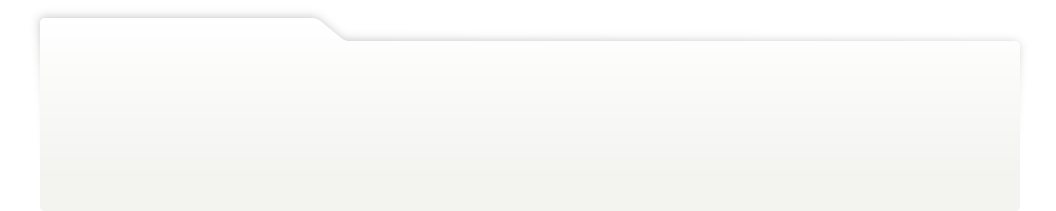
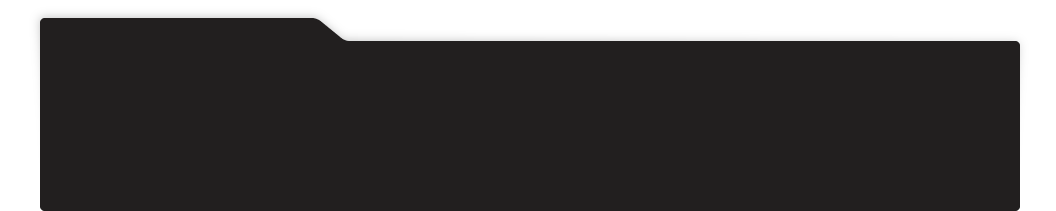
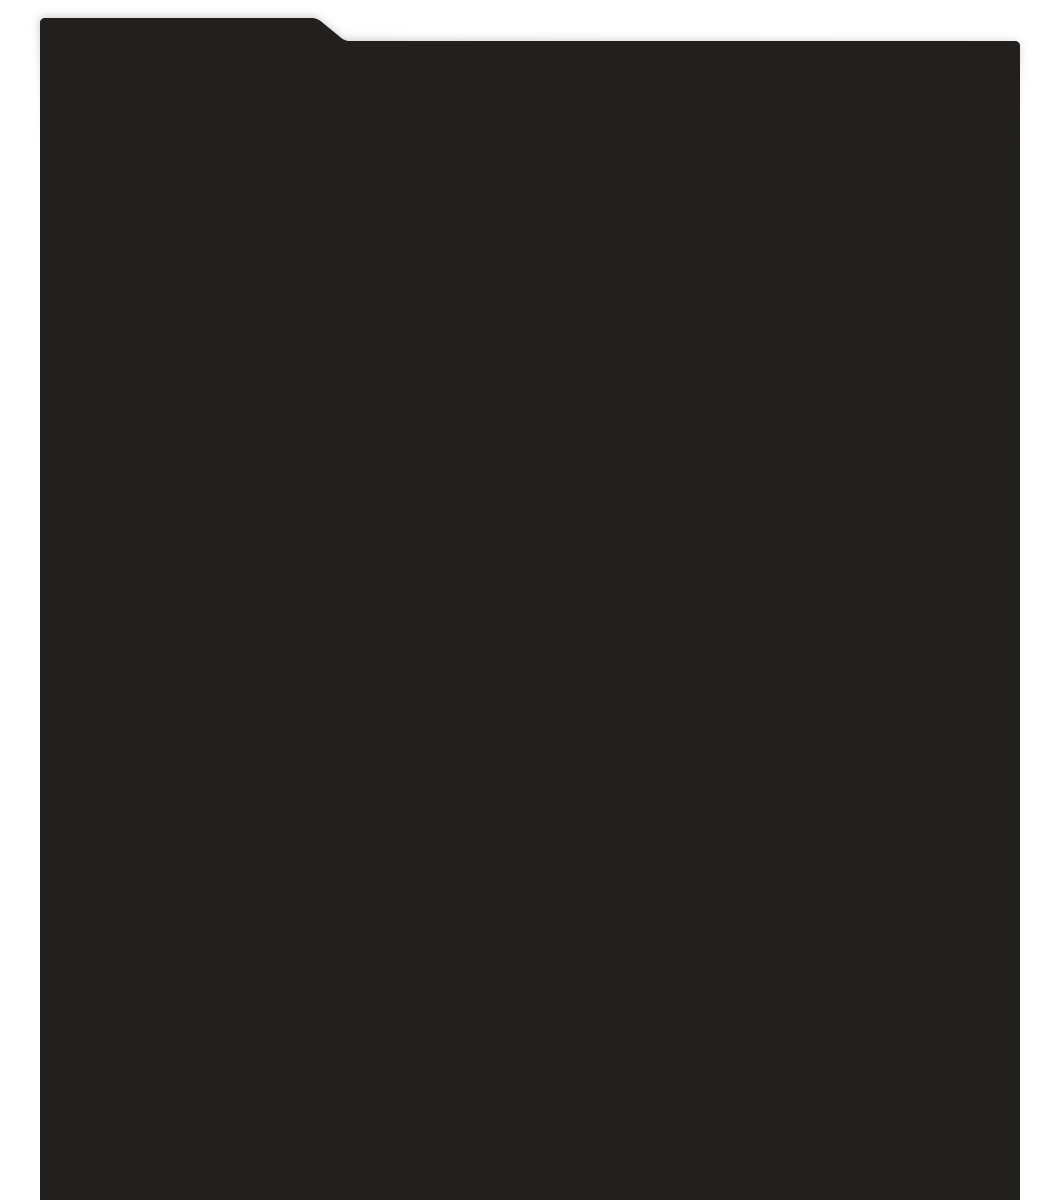
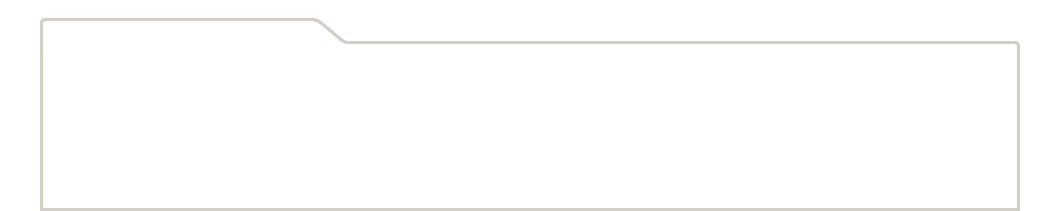
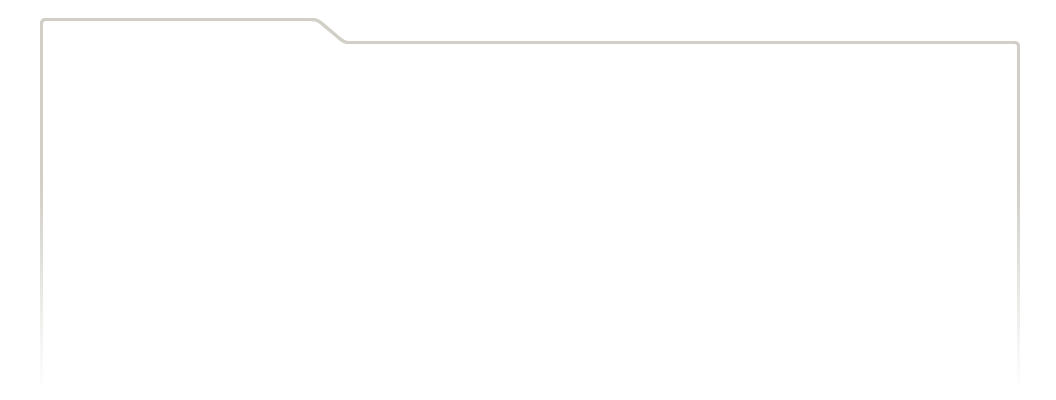
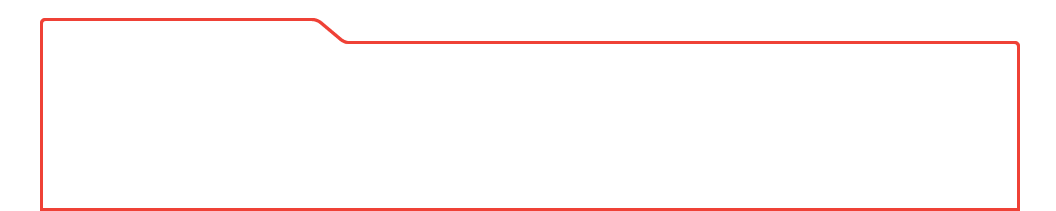
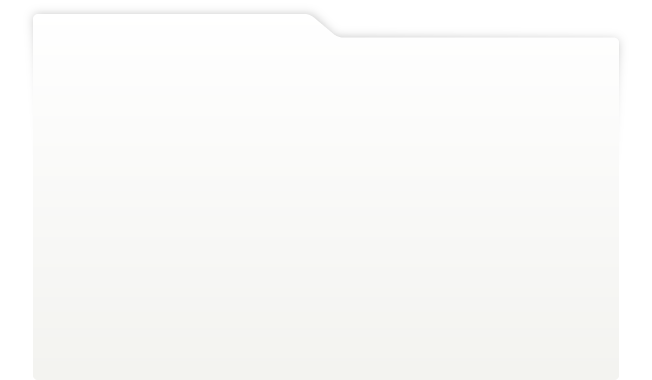
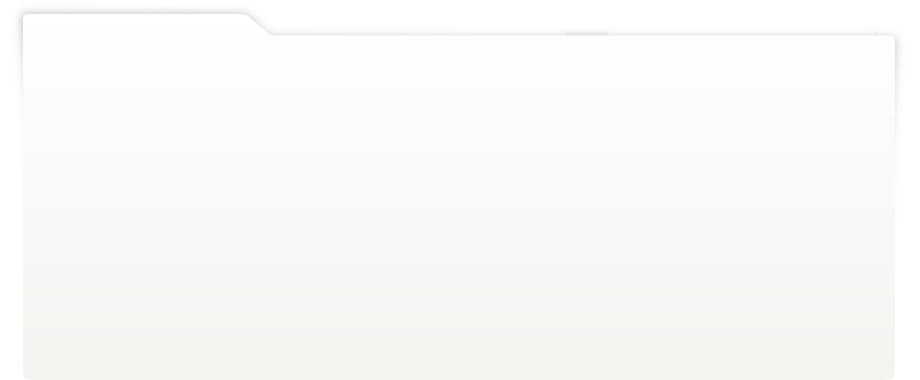
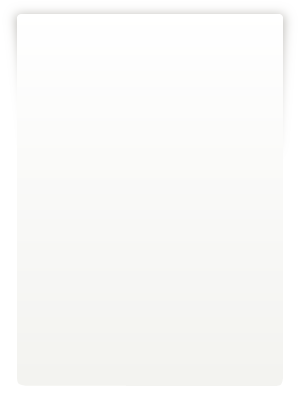
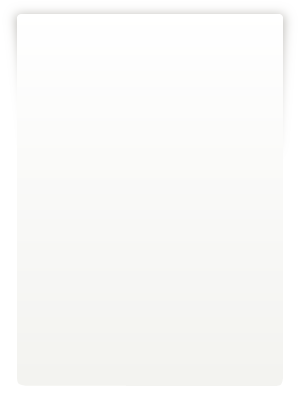
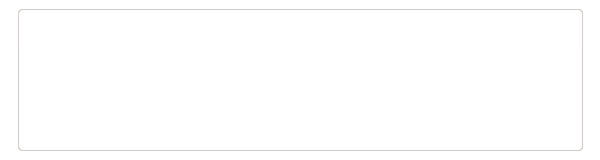
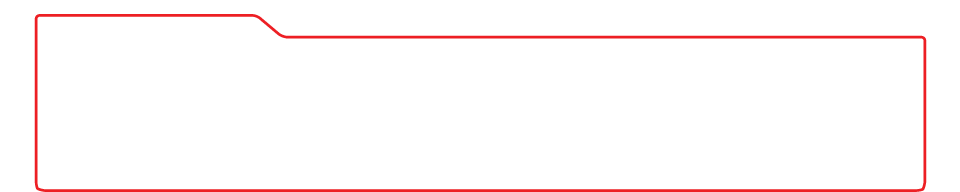
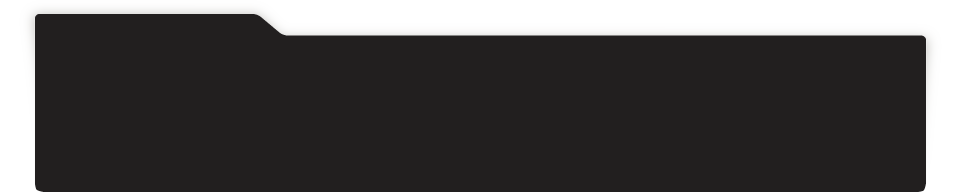
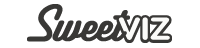
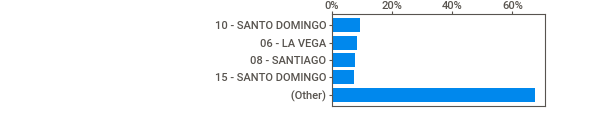
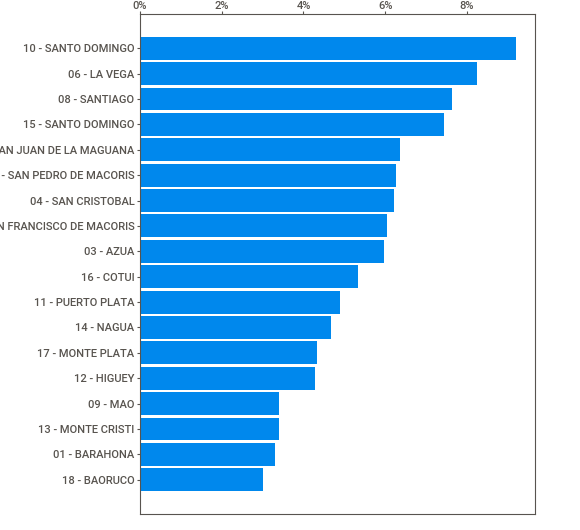
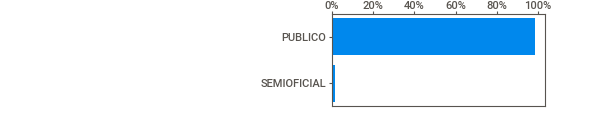
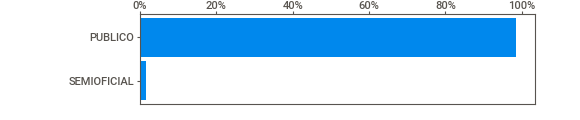
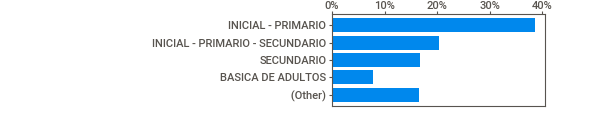
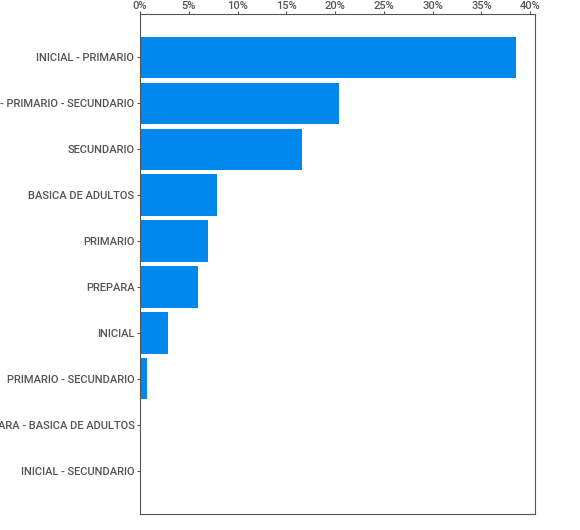
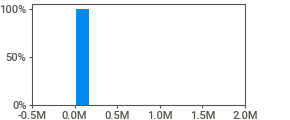
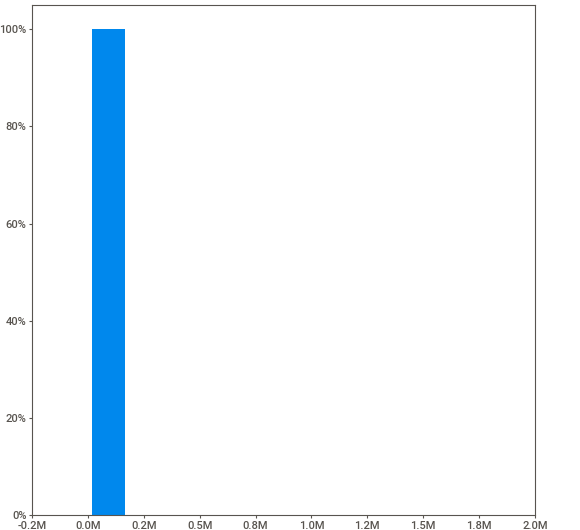
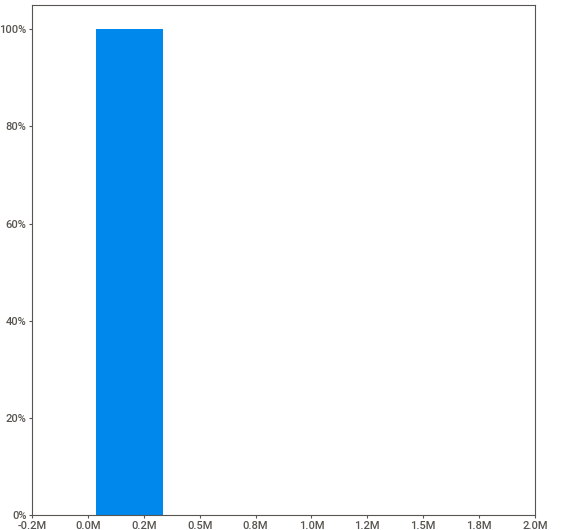
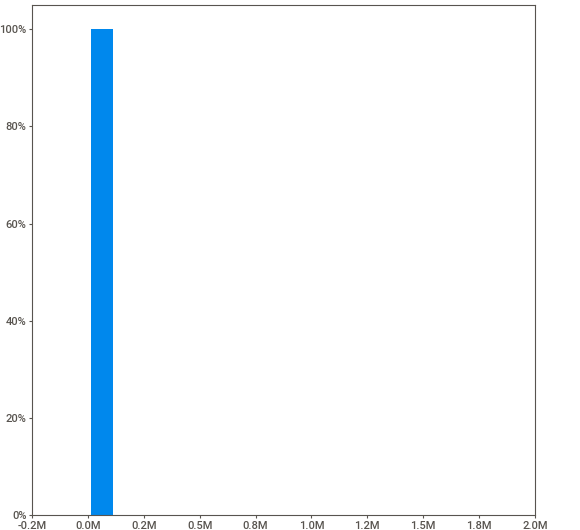
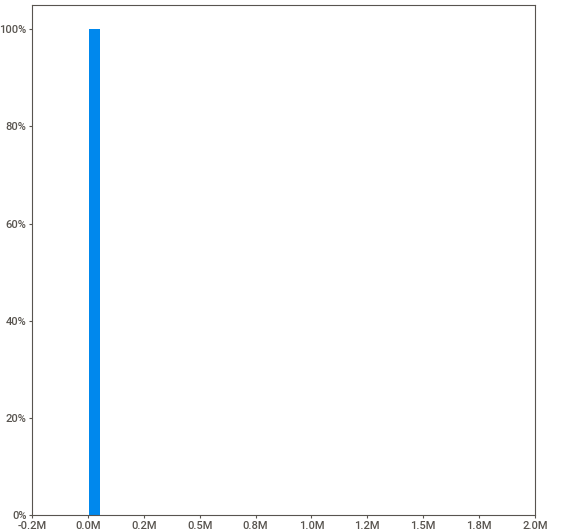
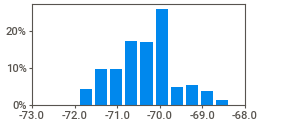
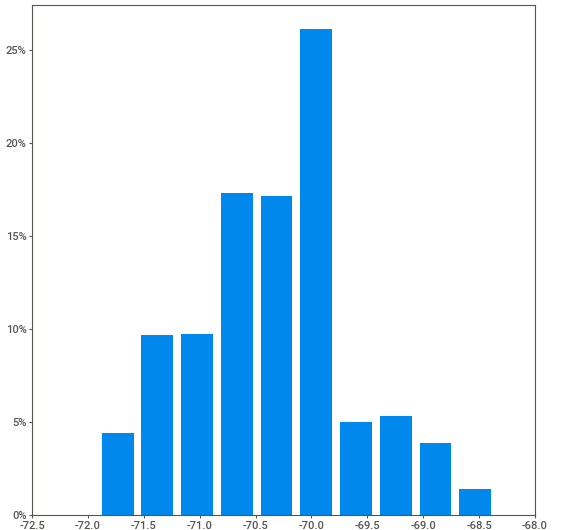
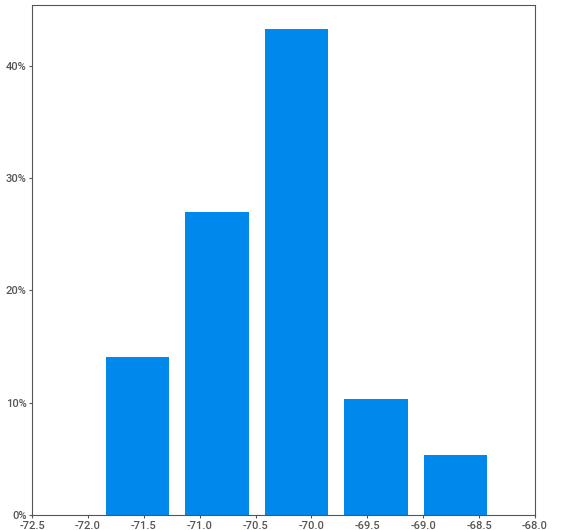
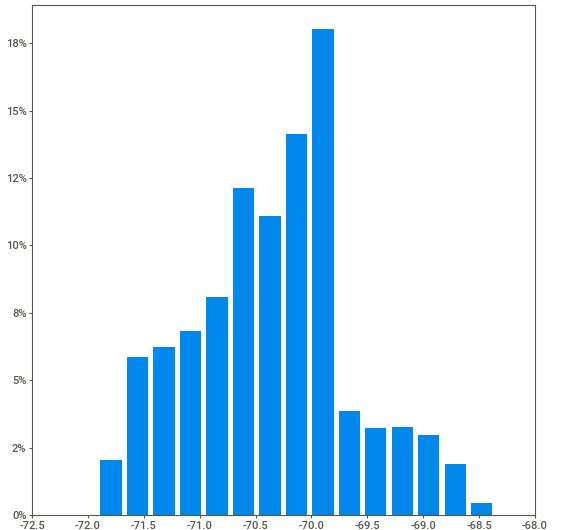
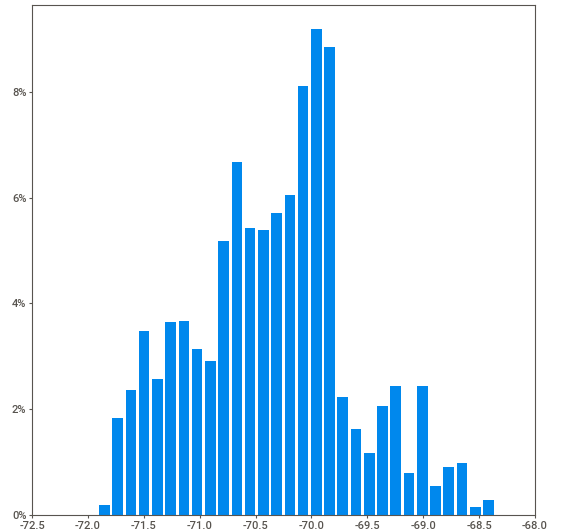
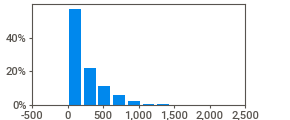
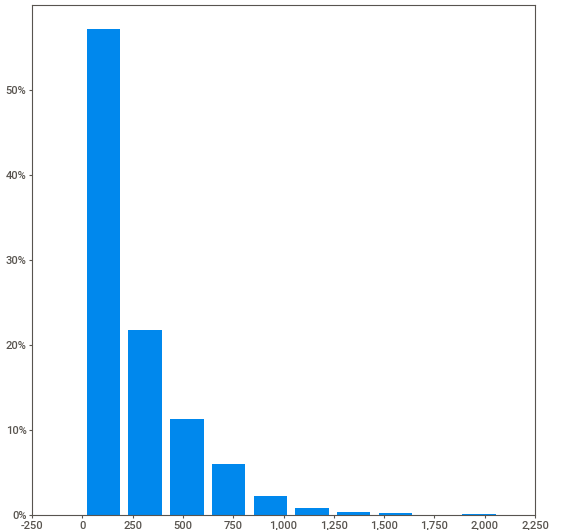
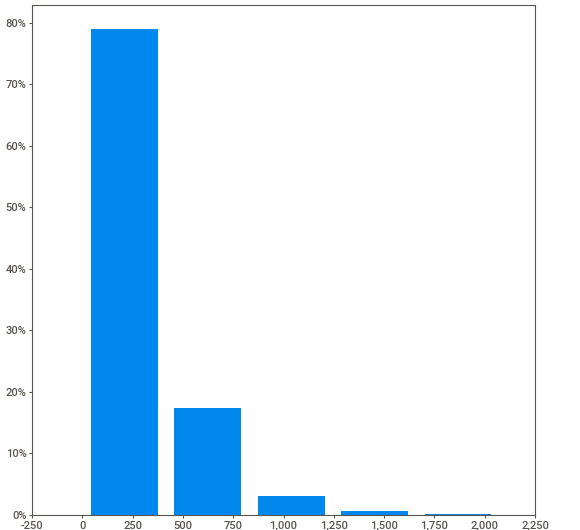
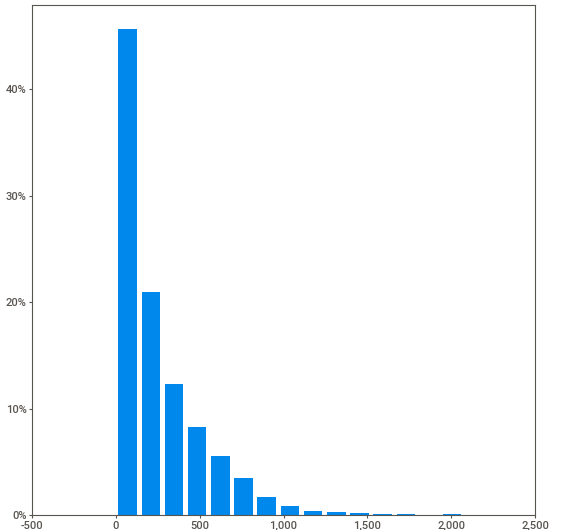
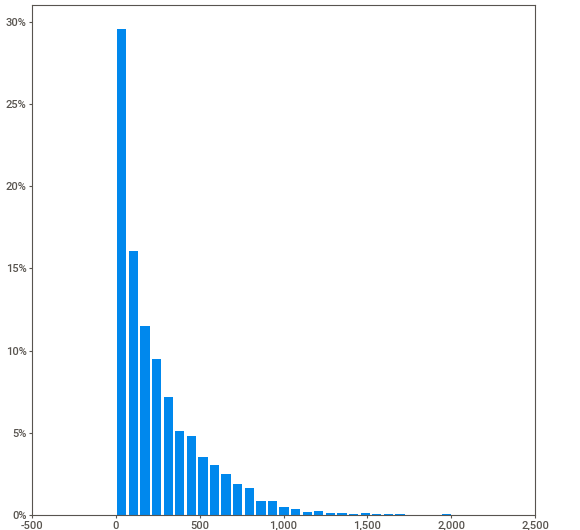
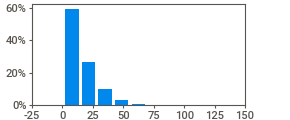
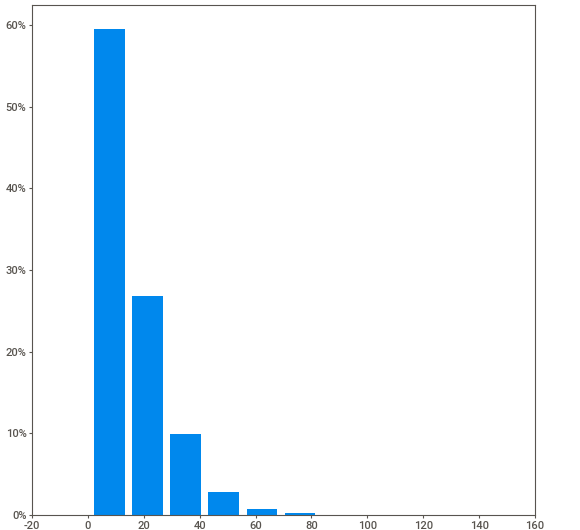
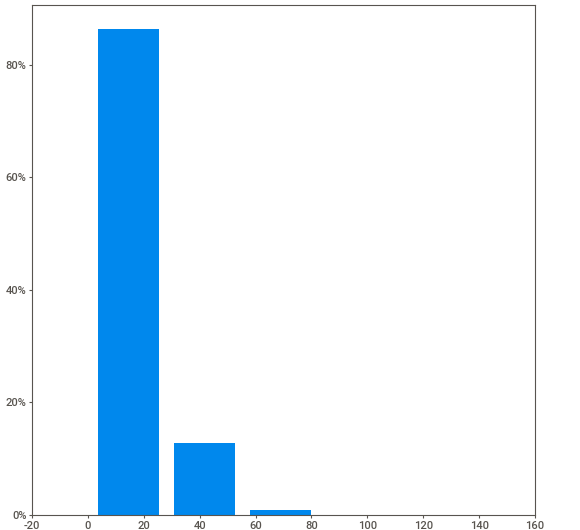
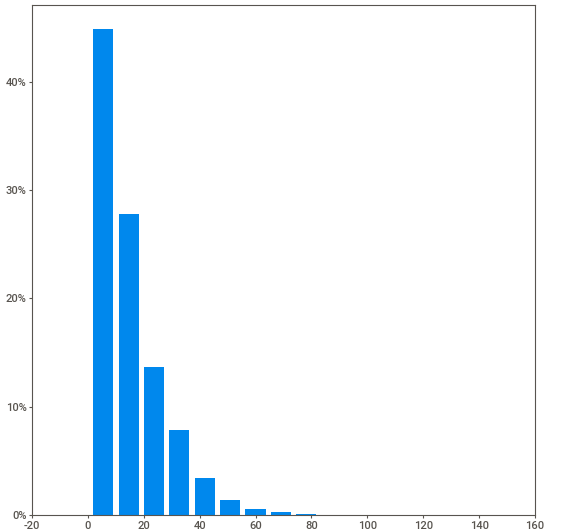
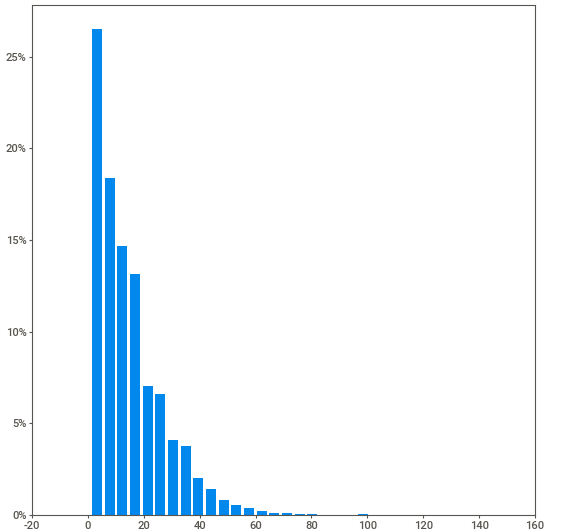
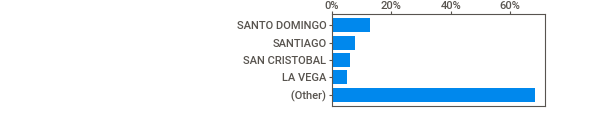
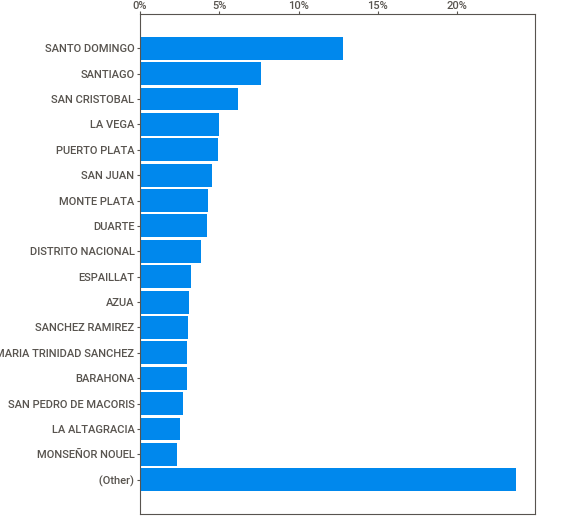
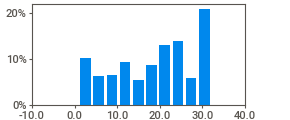
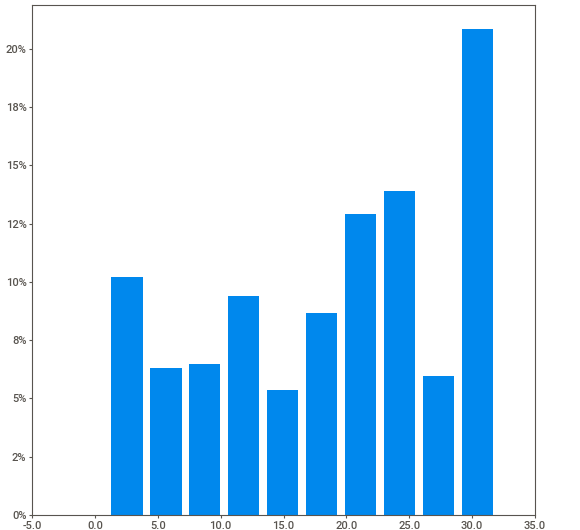
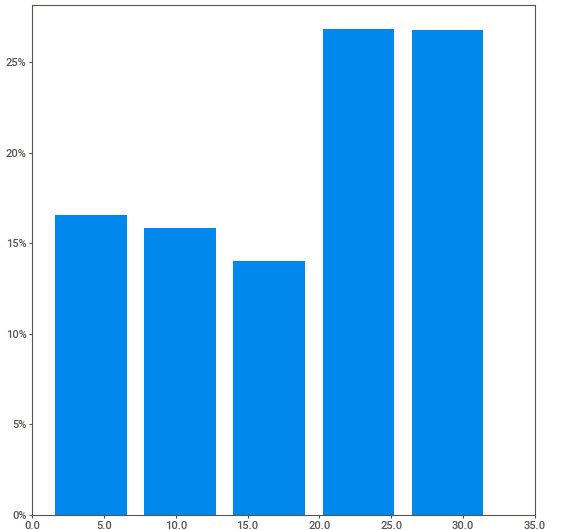
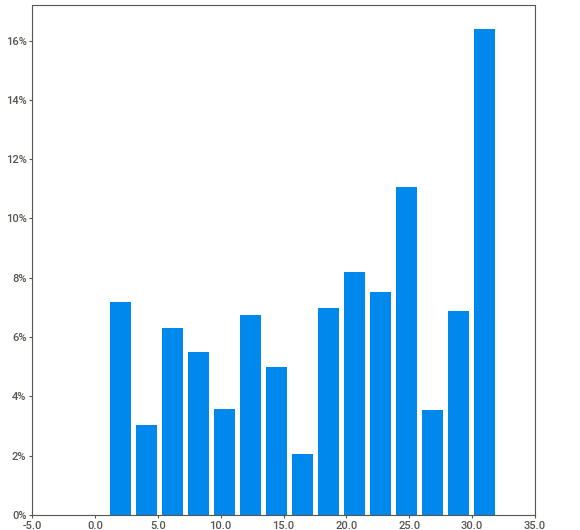
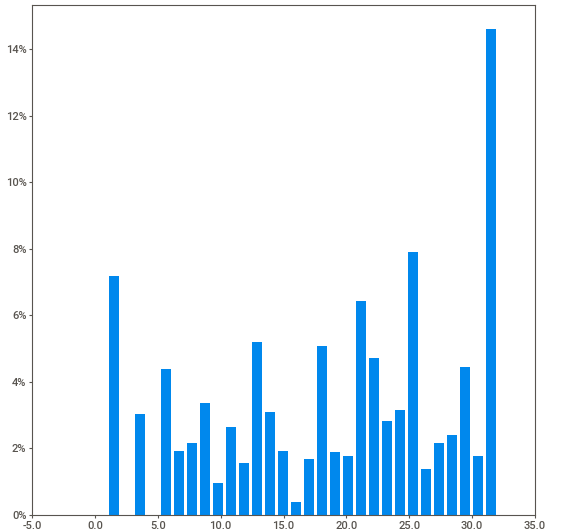
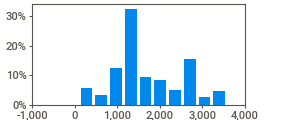
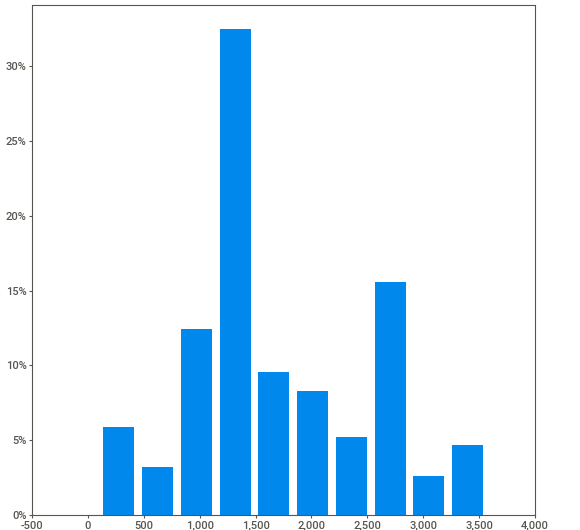
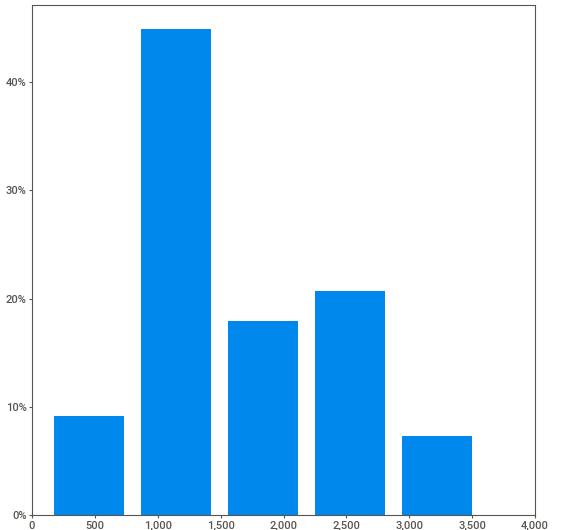
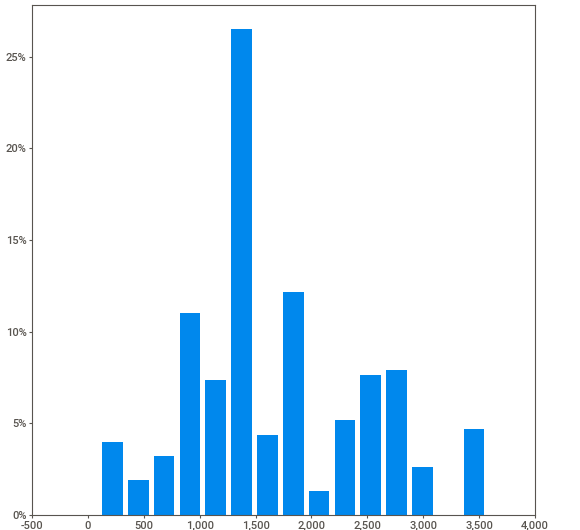
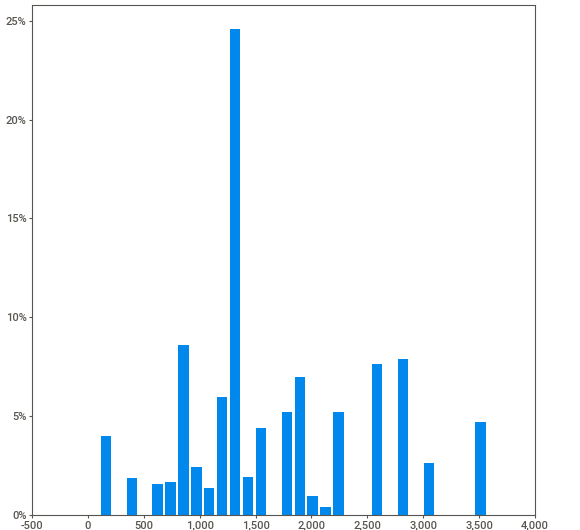
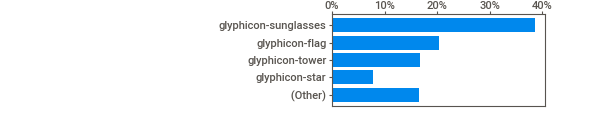
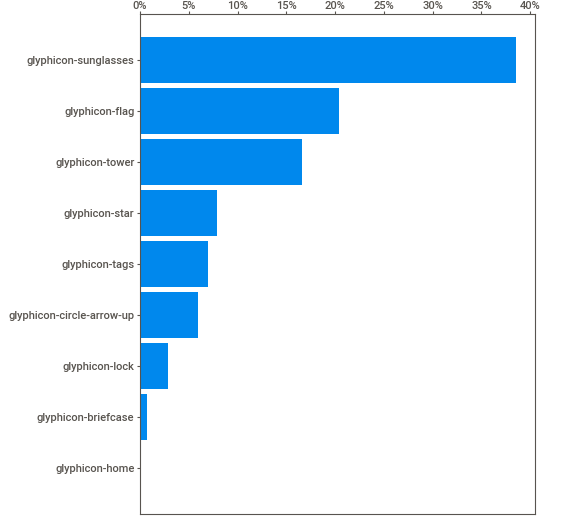
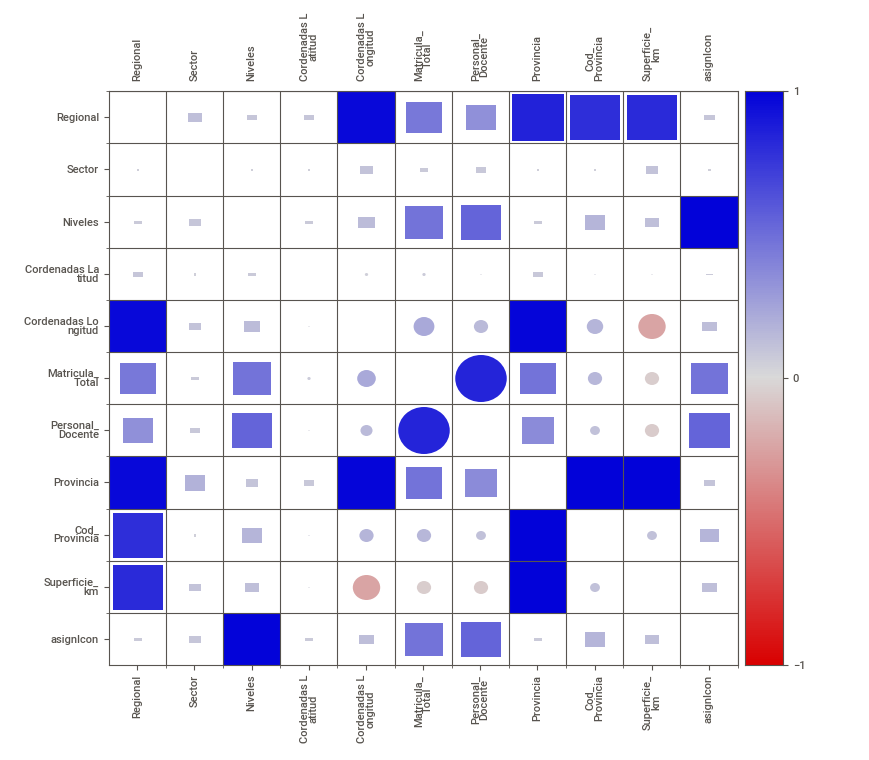
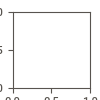

CPU times: user 7.03 s, sys: 7.3 s, total: 14.3 s
Wall time: 5.82 s


In [6]:
%%time
my_report = sv.analyze(df)
my_report.show_html('Report.html')
my_report.show_notebook()

In [7]:
from pandas_profiling import ProfileReport
# Define your profile report:
profile = ProfileReport(df, title='Pandas Profile Report', \
                        html={'style':{'full_width':True}},\
                       explorative=True)
# Save your output file in html forma

profile.to_file(output_file='report.html')



Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
df['Matricula_Total'].describe()

count    7604.000000
mean      251.294450
std       262.360323
min         1.000000
25%        55.000000
50%       166.000000
75%       359.000000
max      2075.000000
Name: Matricula_Total, dtype: float64

In [9]:
df['Personal_Docente'].describe()

count    7604.000000
mean       14.732904
std        12.671730
min         1.000000
25%         5.000000
50%        12.000000
75%        21.000000
max       137.000000
Name: Personal_Docente, dtype: float64

## Cant. Planteles por Provincia

In [10]:
gb_df = df.groupby(['Provincia']).Centros.agg([len]).rename(columns={'len': 'Cant. Centros'})

gb_df['Porcentaje'] = (gb_df['Cant. Centros'] / gb_df['Cant. Centros'].sum()) * 100
gb_df['Porcentaje'] = gb_df['Porcentaje'].apply('{:.2f}%'.format)


gb_df.head(32).sort_values(by='Cant. Centros', ascending=False )

,Cant. Centros,Porcentaje
Provincia,,
SANTO DOMINGO,972,12.78%
SANTIAGO,580,7.63%
SAN CRISTOBAL,472,6.21%
LA VEGA,381,5.01%
PUERTO PLATA,372,4.89%
SAN JUAN,345,4.54%
MONTE PLATA,327,4.30%
DUARTE,321,4.22%
DISTRITO NACIONAL,294,3.87%


## Cant. Estudianes Matriculados por Provincia

In [11]:
gb_df = df.groupby(['Provincia']).Matricula_Total.agg([np.sum, np.min,\
                                                               np.max,np.mean]).rename(columns={'sum': 'Cant. Estudiante',\
                                                                                                'amin': 'Cant. Estudiante Minimo',\
                                                                                               'amax': 'Cant. Estudiante Maximo',\
                                                                                               'mean': 'Cant. Estudiante Promedio'})


gb_df['Cant. Estudiante'] = gb_df['Cant. Estudiante'].round()

gb_df['Cant. Estudiante Maximo'] = gb_df['Cant. Estudiante Maximo'].round()
gb_df['Cant. Estudiante Maximo'] = gb_df['Cant. Estudiante Maximo'].apply('{:,}'.format)

gb_df['Cant. Estudiante Minimo'] = gb_df['Cant. Estudiante Minimo'].round()
gb_df['Cant. Estudiante Minimo'] = gb_df['Cant. Estudiante Minimo'].apply('{:,}'.format)

gb_df['Cant. Estudiante Promedio'] = gb_df['Cant. Estudiante Promedio'].round()
gb_df['Cant. Estudiante Promedio'] = gb_df['Cant. Estudiante Promedio'].apply('{:,}'.format)

gb_df['Porcentaje'] = (gb_df['Cant. Estudiante'] / gb_df['Cant. Estudiante'].sum()) * 100
gb_df['Porcentaje'] = gb_df['Porcentaje'].apply('{:.2f}%'.format)


gb_df['Cant. Estudiante'] = gb_df['Cant. Estudiante'].apply('{:,}'.format)
gb_df.head(32).sort_values(by='Cant. Estudiante Promedio', ascending=False )

,Cant. Estudiante,Cant. Estudiante Minimo,Cant. Estudiante Maximo,Cant. Estudiante Promedio,Porcentaje
Provincia,,,,,
SANTO DOMINGO,"462,582",11,"1,982",476.0,24.21%
DISTRITO NACIONAL,"130,692",10,"2,075",445.0,6.84%
LA ROMANA,"47,036",25,"1,670",413.0,2.46%
LA ALTAGRACIA,"64,622",8,"1,985",335.0,3.38%
PERAVIA,"40,229",5,"1,224",327.0,2.11%
SANTIAGO,"170,850",4,"1,616",295.0,8.94%
SAN PEDRO DE MACORIS,"60,782",3,"1,351",294.0,3.18%
SAN CRISTOBAL,"137,705",6,"1,584",292.0,7.21%
PEDERNALES,"7,315",32,739,261.0,0.38%


## Cant. Planteles por Nivel

In [12]:
gb_df = df.groupby(['Niveles']).Matricula_Total.agg([np.sum, np.min,\
                                                               np.max,np.mean]).rename(columns={'sum': 'Cant. Estudiante',\
                                                                                                'amin': 'Cant. Estudiante Minimo',\
                                                                                               'amax': 'Cant. Estudiante Maximo',\
                                                                                               'mean': 'Cant. Estudiante Promedio'})
gb_df['Cant. Estudiante'] = gb_df['Cant. Estudiante'].round()

gb_df['Cant. Estudiante Maximo'] = gb_df['Cant. Estudiante Maximo'].round()
gb_df['Cant. Estudiante Maximo'] = gb_df['Cant. Estudiante Maximo'].apply('{:,}'.format)

gb_df['Cant. Estudiante Minimo'] = gb_df['Cant. Estudiante Minimo'].round()
gb_df['Cant. Estudiante Minimo'] = gb_df['Cant. Estudiante Minimo'].apply('{:,}'.format)

gb_df['Cant. Estudiante Promedio'] = gb_df['Cant. Estudiante Promedio'].round()
gb_df['Cant. Estudiante Promedio'] = gb_df['Cant. Estudiante Promedio'].apply('{:,}'.format)

gb_df['Porcentaje'] = (gb_df['Cant. Estudiante'] / gb_df['Cant. Estudiante'].sum()) * 100
gb_df['Porcentaje'] = gb_df['Porcentaje'].apply('{:.2f}%'.format)


gb_df['Cant. Estudiante'] = gb_df['Cant. Estudiante'].apply('{:,}'.format)

gb_df.head(32).sort_values(by='Cant. Estudiante Promedio', ascending=False )

,Cant. Estudiante,Cant. Estudiante Minimo,Cant. Estudiante Maximo,Cant. Estudiante Promedio,Porcentaje
Niveles,,,,,
INICIAL - SECUNDARIO,509,509,509,509.0,0.03%
PREPARA - BASICA DE ADULTOS,844,98,746,422.0,0.04%
PRIMARIO,"21,137",1,813,40.0,1.11%
SECUNDARIO,"503,848",9,"1,971",398.0,26.37%
INICIAL - PRIMARIO - SECUNDARIO,"589,628",9,"2,075",380.0,30.86%
PREPARA,"142,395",13,"1,017",317.0,7.45%
PRIMARIO - SECUNDARIO,"12,398",5,"1,495",218.0,0.65%
INICIAL - PRIMARIO,"519,782",2,"1,720",177.0,27.20%
INICIAL,"33,250",10,"1,391",153.0,1.74%


## Top de Distrito Educativo por Cant. de Estudiantes

In [13]:
gb_df = df.groupby(['Distrito']).Matricula_Total.agg([np.sum, np.min,\
                                                               np.max,np.mean]).rename(columns={'sum': 'Cant. Estudiante',\
                                                                                                'amin': 'Cant. Estudiante Minimo',\
                                                                                               'amax': 'Cant. Estudiante Maximo',\
                                                                                               'mean': 'Cant. Estudiante Promedio'})
gb_df['Cant. Estudiante'] = gb_df['Cant. Estudiante'].round()

gb_df['Cant. Estudiante Maximo'] = gb_df['Cant. Estudiante Maximo'].round()
gb_df['Cant. Estudiante Maximo'] = gb_df['Cant. Estudiante Maximo'].apply('{:,}'.format)

gb_df['Cant. Estudiante Minimo'] = gb_df['Cant. Estudiante Minimo'].round()
gb_df['Cant. Estudiante Minimo'] = gb_df['Cant. Estudiante Minimo'].apply('{:,}'.format)

gb_df['Cant. Estudiante Promedio'] = gb_df['Cant. Estudiante Promedio'].round()
gb_df['Cant. Estudiante Promedio'] = gb_df['Cant. Estudiante Promedio'].apply('{:,}'.format)

gb_df['Porcentaje'] = (gb_df['Cant. Estudiante'] / gb_df['Cant. Estudiante'].sum()) * 100
gb_df['Porcentaje'] = gb_df['Porcentaje'].apply('{:.2f}%'.format)

gb_df['Cant. Estudiante'] = gb_df['Cant. Estudiante'].apply('{:,}'.format)
gb_df.head(10).sort_values(by='Porcentaje', ascending=False )

,Cant. Estudiante,Cant. Estudiante Minimo,Cant. Estudiante Maximo,Cant. Estudiante Promedio,Porcentaje
Distrito,,,,,
0103 - BARAHONA,"29,377",6,"1,218",280.0,1.54%
0205 - SAN JUAN ESTE,"19,373",10,967,192.0,1.01%
0201 - COMENDADOR,"11,780",7,934,203.0,0.62%
0203 - LAS MATAS DE FARFAN,"11,149",3,"1,137",138.0,0.58%
0104 - CABRAL,"7,640",6,797,182.0,0.40%
0102 - ENRIQUILLO,"7,358",9,712,142.0,0.39%
0101 - PEDERNALES,"7,315",32,739,261.0,0.38%
0105 - VICENTE NOBLE,"6,214",36,809,259.0,0.33%
0204 - EL CERCADO,"5,485",3,448,108.0,0.29%


## Promedio de Cant. Estudiantes en los Planteles por Provincia

In [14]:
gb_df = df.groupby(['Provincia']).agg({'Centros': 'count','Matricula_Total': 'sum'})\
.rename(columns={'Centros':'Cnt. Centros','Matricula_Total': 'Cnt. Estudiantes'})\
.reset_index().sort_values('Cnt. Estudiantes',ascending=False)       
gb_df['% de cnt Estudiantes'] = (gb_df['Cnt. Estudiantes'] / gb_df['Cnt. Estudiantes'].sum()) * 100

gb_df['indice estudiantil x Plantel'] = (gb_df['Cnt. Estudiantes']/gb_df['Cnt. Centros'])
gb_df['indice estudiantil x Plantel'] = gb_df['indice estudiantil x Plantel'].round()

gb_df.reset_index().sort_values('% de cnt Estudiantes',ascending=False)
gb_df['% de cnt Estudiantes'] = gb_df['% de cnt Estudiantes'].apply('{:.2f}%'.format)
gb_df

,Provincia,Cnt. Centros,Cnt. Estudiantes,% de cnt Estudiantes,indice estudiantil x Plantel
30,SANTO DOMINGO,972,462582,24.21%,476.0
28,SANTIAGO,580,170850,8.94%,295.0
23,SAN CRISTOBAL,472,137705,7.21%,292.0
4,DISTRITO NACIONAL,294,130692,6.84%,445.0
14,LA VEGA,381,79073,4.14%,208.0
12,LA ALTAGRACIA,193,64622,3.38%,335.0
21,PUERTO PLATA,372,64052,3.35%,172.0
26,SAN PEDRO DE MACORIS,207,60782,3.18%,294.0
25,SAN JUAN,345,54137,2.83%,157.0
0,AZUA,233,52333,2.74%,225.0


## Promedio de Estudiantes atendidos por Docente por Provincia

In [15]:
gb_df = df.groupby(['Provincia']).agg({'Centros': 'count','Personal_Docente': 'sum','Matricula_Total': 'sum'})\
.rename(columns={'Centros':'Cnt. Centros','Personal_Docente': 'Cnt. Docente','Matricula_Total': 'Cnt. Estudiantes'})\
.reset_index().sort_values('Cnt. Estudiantes',ascending=False)       
gb_df['% de cnt Estudiantes'] = (gb_df['Cnt. Estudiantes'] / gb_df['Cnt. Estudiantes'].sum()) * 100


gb_df['indice de Docente x Estudiantes'] = (gb_df['Cnt. Estudiantes']/gb_df['Cnt. Docente'])


gb_df['% de cnt Estudiantes'] = gb_df['% de cnt Estudiantes'].apply('{:.2f}%'.format)
gb_df.reset_index().sort_values('indice de Docente x Estudiantes',ascending=False)
gb_df

,Provincia,Cnt. Centros,Cnt. Docente,Cnt. Estudiantes,% de cnt Estudiantes,indice de Docente x Estudiantes
30,SANTO DOMINGO,972,20775,462582,24.21%,22.266282
28,SANTIAGO,580,8961,170850,8.94%,19.065952
23,SAN CRISTOBAL,472,7151,137705,7.21%,19.256747
4,DISTRITO NACIONAL,294,7304,130692,6.84%,17.893209
14,LA VEGA,381,4863,79073,4.14%,16.260127
12,LA ALTAGRACIA,193,2189,64622,3.38%,29.521243
21,PUERTO PLATA,372,4039,64052,3.35%,15.858381
26,SAN PEDRO DE MACORIS,207,3562,60782,3.18%,17.064009
25,SAN JUAN,345,4677,54137,2.83%,11.575155
0,AZUA,233,3332,52333,2.74%,15.706182


In [16]:
var = 'Matricula_Total'
data = pd.concat([df['Personal_Docente'], df[var]], axis=1)
data.plot.scatter(x=var, y='Personal_Docente', ylim=(0,500));

In [17]:
top_cargo = (
    df["Niveles"].value_counts().sort_values(ascending=False).head(5).index.values
)
sns.boxplot(
    y="Niveles",
    x="Personal_Docente",
    data=df[df["Niveles"].isin(top_cargo)],
    orient="h",
);


In [18]:
df.columns

Index(['Regional', 'Distrito', 'Centros', 'Sector', 'Niveles',
       'Cordenadas Latitud', 'Cordenadas Longitud', 'Matricula_Total',
       'Personal_Docente', 'Planta_Fisica', 'Provincia', 'Municipio',
       'Cod_Provincia', 'Superficie_km', 'asignIcon'],
      dtype='object')